In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import os
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.15.0


In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = r'/content/drive/MyDrive/Traffic Signals/myData',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(

    directory = r'/content/drive/MyDrive/Traffic Signals/myData',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 73193 files belonging to 43 classes.
Found 73193 files belonging to 43 classes.


In [ ]:
path = '/content/drive/MyDrive/Traffic Signals'
lab = pd.read_csv('/content/drive/MyDrive/Traffic Signals/labels.csv')

<ipython-input-13-fccbbe83799a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')


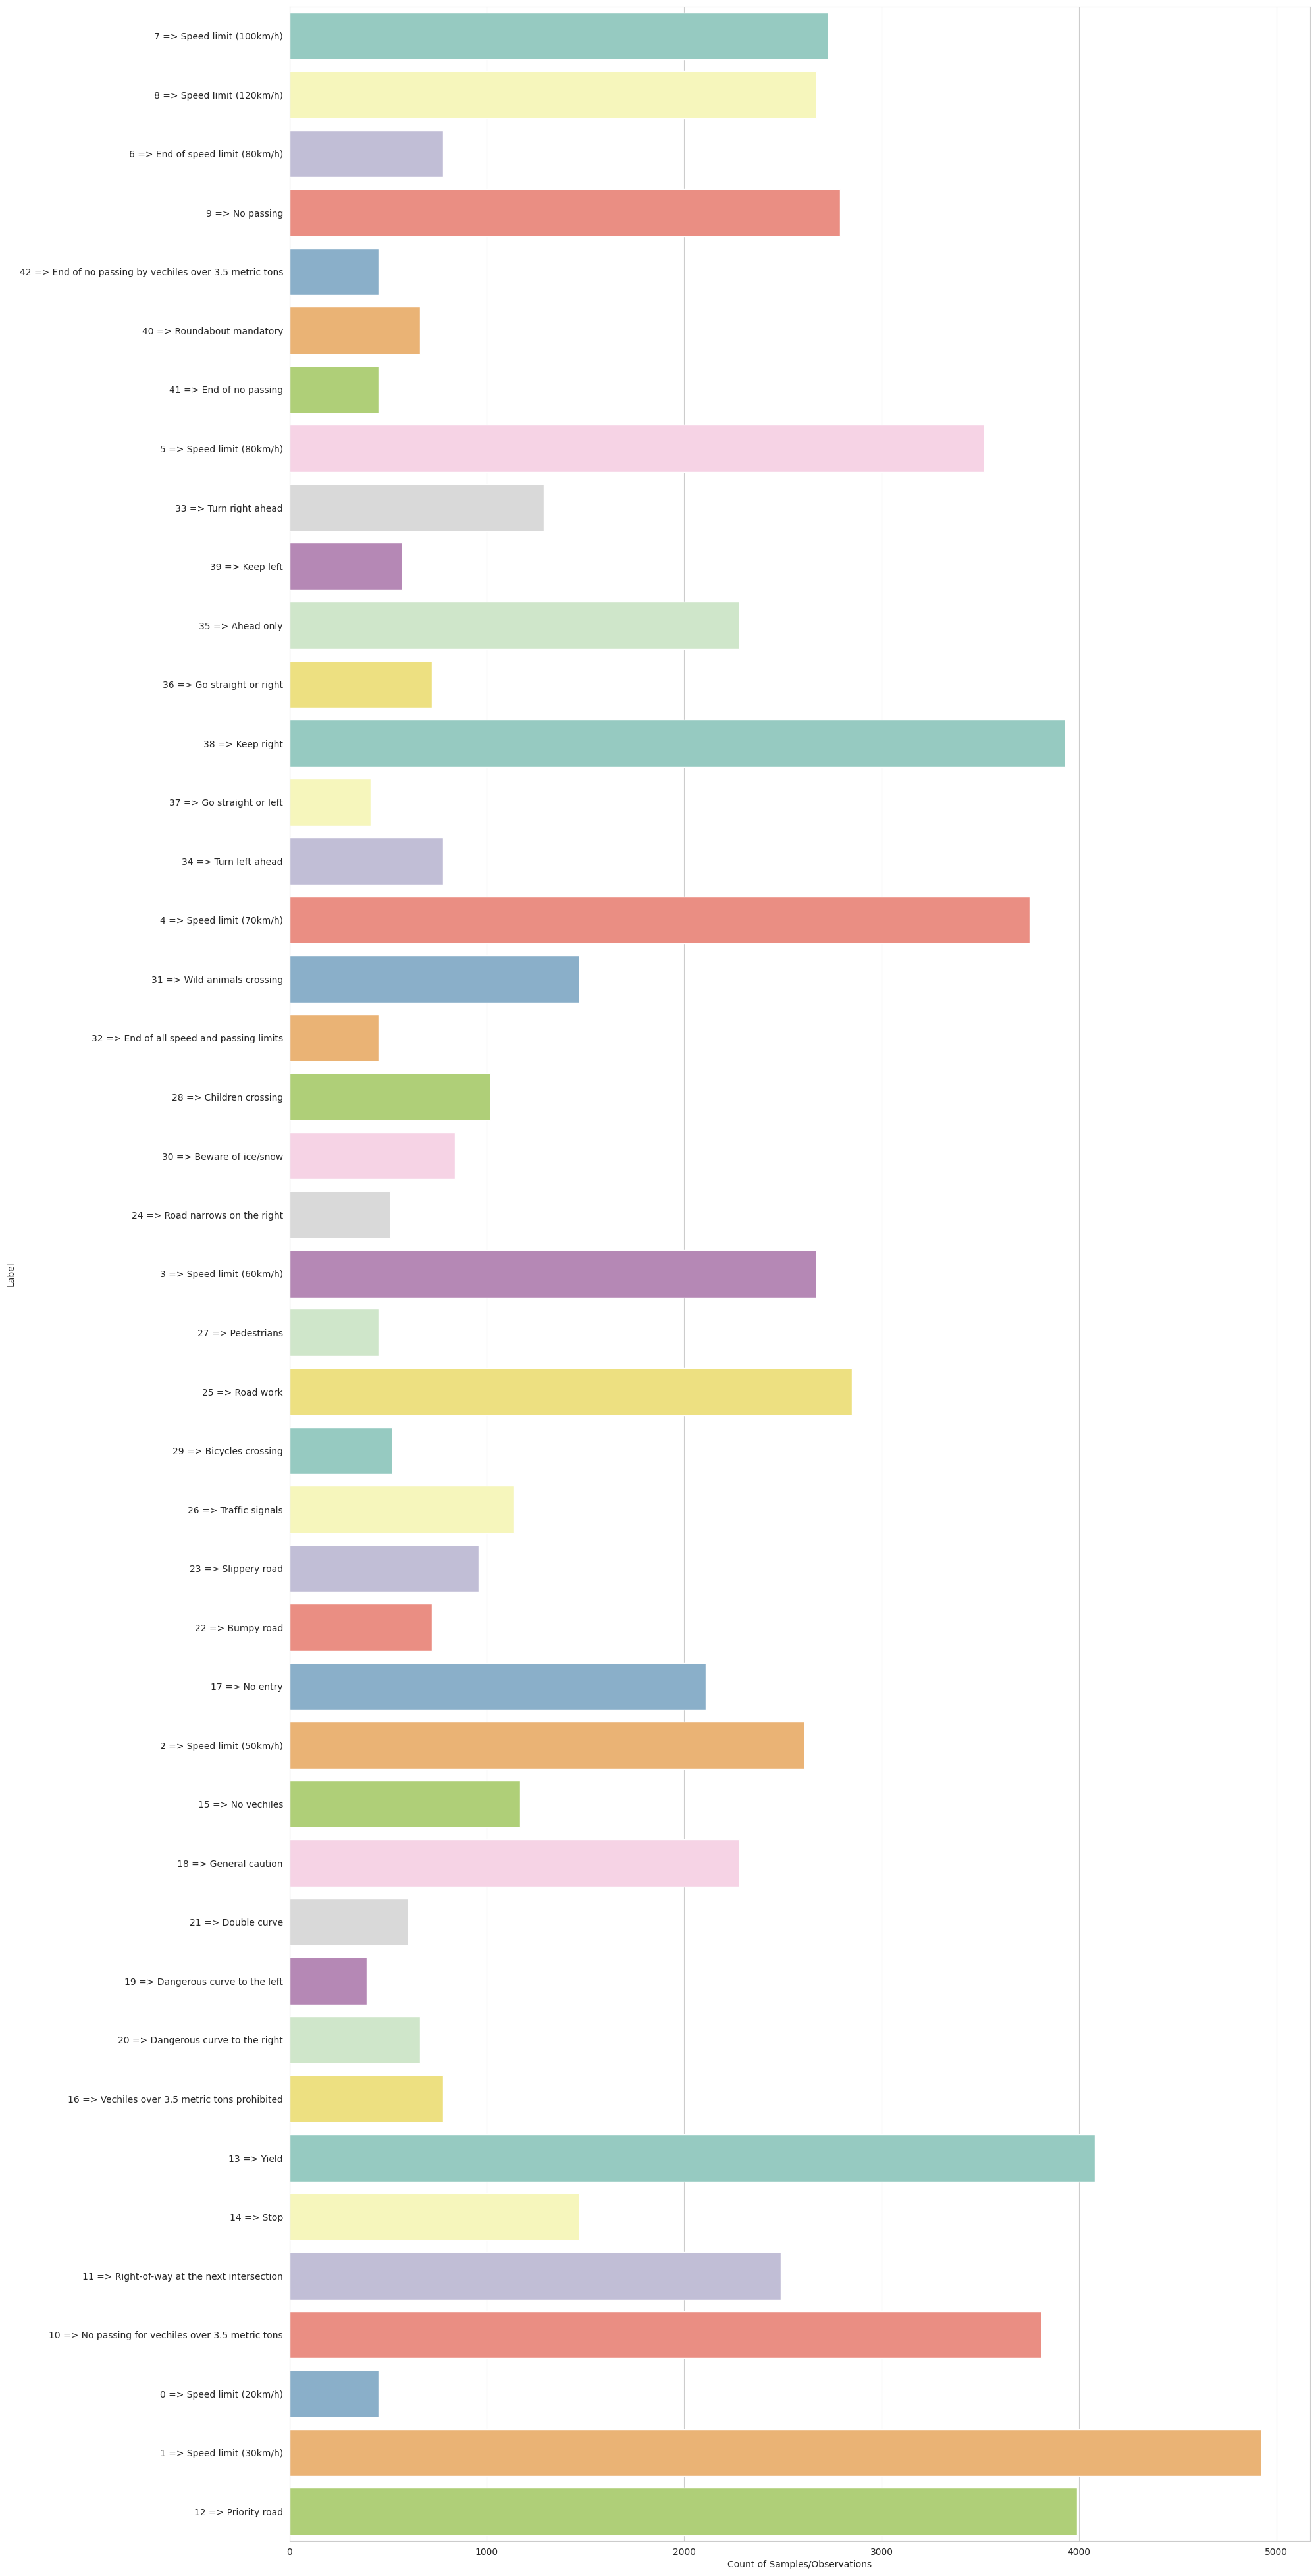

In [ ]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (20, 50))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

In [ ]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('/content/drive/MyDrive/Traffic Signals/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73193 images belonging to 43 classes.


In [ ]:
X , y = data.next()

In [ ]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [ ]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

In [ ]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [ ]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

In [ ]:
n_epochs = 50
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1,
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

In [ ]:
# Saving the model
model.save('TSC_model.h5')

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

In [ ]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();